# Asian Restaurants in UK

### Sophia Wu 29/11/2020


## Introduction

More and more Hong Kong people are planned to immigrate to other countries due to the unstable political environment after Anti-Extradition Law Amendment Bill Movement in Hong Kong. UK would be one of the popular countries for immigration since Hong Kong was the colonise of UK before 1997 and the relaxed immigration policy to BNO holders. They think they are more familiar with British culture and have lower boundaries with the relaxed immigration policy to BNO holders. More Hong Kong People immigrate to the UK, the demand for Asian / Chinese restaurants would increase. Therefore, I would like to find out the location which is suitable for opening a Asian restaurant in United Kingdom. 


## Business Problem & Problem statment

The UK local catering company and Hong Kong immigrants would be our main target client. UK local catering company can enlarge their business with the growing customer to Asian/Chinese cuisine from Hong Kong immigrants. Hong Kong immigrant can also invest in the UK for the chinese restaurant business which can bring Hong Kong Cusine to the UK. 

To find out the location which is suitable for opening a Hong Kong or Chinese restaurant in UK

1. Districts with fewer chinese restaurant in order to build the reputation faster. 
2. Districts with more low ranking restaurant in order to have less competition since we are targeting with the high standard of Traditional Hong Kong Cusine

## Data

To solve the business problem, the following data is required for analysis.

The data of UK containing the districts name and districts' Latitude and Longitude coordinates 

Venue places with the information of location, name, categories 



## Methodology

- The data of UK containing the districts name and districts' Latitude and Longitude coordinates is collected from https://www.geodatos.net/en/coordinates/united-kingdom

- Venue places with the information of location, name, categories in the UK would be collected from FourSquare. The frequency , venue type and rating would be saved in dataframe. 

- Data visulization in different graphs sorted on venue rankings. 

In [1]:
import pandas as pd
import numpy as np 
import json 

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim 

import requests 
from pandas.io.json import json_normalize 


import matplotlib.cm as cm
import matplotlib.colors as colors


from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes
import folium 

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

import seaborn as sns


Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.9.1
  latest version: 4.9.2

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.11.8  |       ha878542_0         145 KB  conda-forge
    certifi-2020.11.8          |   py36h5fab9bb_0         150 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-2.0.0                |     pyh9f0ad1d_0          63 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         392 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch

In [2]:

def geo_location(addres):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    CLIENT_ID = 'IBCO3VSKA0BY3IGYQD5NRR0KPYWTYFAIM4AQ1XY5ZYPQSKZG' # your Foursquare ID
    CLIENT_SECRET = 'PXJEGTVL345TLAHI3HBKVJCJEBOVZRAJI4LIOGPUWBLSJTP5' # your Foursquare Secret
    ACCESS_TOKEN = 'X0LXO5V0SRKS0TWHUJQYD3C05TDK11JW0AJAO2DNWYS1AXNH' # your FourSquare Access Token
    VERSION = '20180605'
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    CLIENT_ID = 'EHHM3WPR1FYC1MKLTGOPOTUSEOLYSRQ53LJU5E2PKPNXDXYQ' # your Foursquare ID
    CLIENT_SECRET = 'DVGMPR0VTJXT201M0VBXW0Q1T4BUIWQLVGMTVTCPU120IH3D' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

### Getting the geographical coordinates of uk cities from csv files from geodatos

In [3]:
myuk_df = pd.read_csv('uk_orginal.csv')
myuk_df.head()

,City,Coordinates
0,London,"51.50853, -0.12574"
1,Birmingham,"52.48142, -1.89983"
2,Liverpool,"53.41058, -2.97794"
3,Nottingham,"52.9536, -1.15047"
4,Sheffield,"53.38297, -1.4659"


In [4]:
address = 'United Kingdom'
geo_location(address)

(54.7023545, -3.2765753)

### Data Cleaning 
The data is quite simple and clean which has no missing data, but Latitude and Longitude are in the same column. So, the coordinate woule be slipted in to 2 column in Latitude and Longitude accordingly

In [5]:
myuk_df[['Latitude','Longitude']] = myuk_df['Coordinates'].str.split(', ',expand=True)
myuk_df.head()

myuk_df['Latitude'] = myuk_df['Latitude'].astype('float')
myuk_df['Longitude'] = myuk_df['Longitude'].astype('float')
myuk_df.head()

,City,Coordinates,Latitude,Longitude
0,London,"51.50853, -0.12574",51.50853,-0.12574
1,Birmingham,"52.48142, -1.89983",52.48142,-1.89983
2,Liverpool,"53.41058, -2.97794",53.41058,-2.97794
3,Nottingham,"52.9536, -1.15047",52.95360,-1.15047
4,Sheffield,"53.38297, -1.4659",53.38297,-1.46590


In [6]:
print('The dataframe has {} Cities.'.format(
        len(myuk_df['City'].unique()),
        myuk_df.shape[0]
    )
)

The dataframe has 20 Cities.


### Get Data for Asian restaurant in UK

In [7]:
CLIENT_ID = 'IBCO3VSKA0BY3IGYQD5NRR0KPYWTYFAIM4AQ1XY5ZYPQSKZG' # your Foursquare ID
CLIENT_SECRET = 'PXJEGTVL345TLAHI3HBKVJCJEBOVZRAJI4LIOGPUWBLSJTP5' # your Foursquare Secret
ACCESS_TOKEN = 'X0LXO5V0SRKS0TWHUJQYD3C05TDK11JW0AJAO2DNWYS1AXNH' # your FourSquare Access Token
VERSION = '20180605'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: IBCO3VSKA0BY3IGYQD5NRR0KPYWTYFAIM4AQ1XY5ZYPQSKZG
CLIENT_SECRET:PXJEGTVL345TLAHI3HBKVJCJEBOVZRAJI4LIOGPUWBLSJTP5


In [8]:
column_names=['City','ID','Name']
asia_rest_uk=pd.DataFrame(columns=column_names)
count = 1
for row in myuk_df.values.tolist():
    City, Coordinates, Latitude, Longitude = row
    venues = get_venues(Latitude,Longitude)
    asia_restaurants = venues[(venues['Category']=='Asian Restaurant') | (venues['Category']=='Chinese Restaurant') | (venues['Category']=='Thai Restaurant') | (venues['Category']=='Sushi Restaurant') | (venues['Category']=='Japanese Curry Restaurant')]
    print('(',count,'/',len(myuk_df),')','Asia Restaurants in '+ City +', '+':'+str(len(asia_restaurants)))
    print(row)
    for resturant_detail in asia_restaurants.values.tolist():
        id, name , category=resturant_detail
        asia_rest_uk = asia_rest_uk.append({'City': City,
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 20 ) Asia Restaurants in London, :4
['London', '51.50853, -0.12574', 51.50853, -0.12574]
( 2 / 20 ) Asia Restaurants in Birmingham, :0
['Birmingham', '52.48142, -1.89983', 52.48142, -1.89983]
( 3 / 20 ) Asia Restaurants in Liverpool, :0
['Liverpool', '53.41058, -2.97794', 53.41058, -2.97794]
( 4 / 20 ) Asia Restaurants in Nottingham, :3
['Nottingham', '52.9536, -1.15047', 52.9536, -1.15047]
( 5 / 20 ) Asia Restaurants in Sheffield, :4
['Sheffield', '53.38297, -1.4659', 53.38297, -1.4659]
( 6 / 20 ) Asia Restaurants in Bristol, :3
['Bristol', '51.45523, -2.59665', 51.45523, -2.59665]
( 7 / 20 ) Asia Restaurants in Glasgow, :3
['Glasgow', '55.86515, -4.25763', 55.86515, -4.25763]
( 8 / 20 ) Asia Restaurants in Leicester, :1
['Leicester', '52.6386, -1.13169', 52.6386, -1.13169]
( 9 / 20 ) Asia Restaurants in Leeds, :2
['Leeds', '53.79648, -1.54785', 53.79648, -1.54785]
( 10 / 20 ) Asia Restaurants in Cardiff, :0
['Cardiff', '51.48, -3.18', 51.48, -3.18]
( 11 / 20 ) Asia Restaurants 

In [9]:
# Save the information so far to a .csv file due to limited calls on FourSquare
asia_rest_uk.to_csv('asia_rest_uk.csv')

In [10]:
asia_uk = pd.read_csv('asia_rest_uk.csv')
asia_uk

,Unnamed: 0,City,ID,Name
0,0,London,527bee27498e2ccd501fe6dc,Sticks'n'Sushi
1,1,London,58c575e4260327384ab298a9,wagamama
2,2,London,4c8d8002cf3ea14343c1fe51,Thai Square
3,3,London,5c10e0201de76500398bf8e0,CoCo Ichibanya
4,4,Nottingham,564652ba498e954762aacbfc,ZAAP Thai street food
5,5,Nottingham,4b7bfb82f964a520f1762fe3,wagamama
6,6,Nottingham,4bb2342214cfd13a6d9d14ab,Chino Latino
7,7,Sheffield,4e58d2eb45dd7055928d8026,Edo Sushi
8,8,Sheffield,4b61f234f964a520bb2c2ae3,wagamama
9,9,Sheffield,4babe37cf964a52070d23ae3,Sakushi


In [11]:
asia_uk.columns = ['Index','City','ID','Name']
asia_uk.shape

(36, 4)

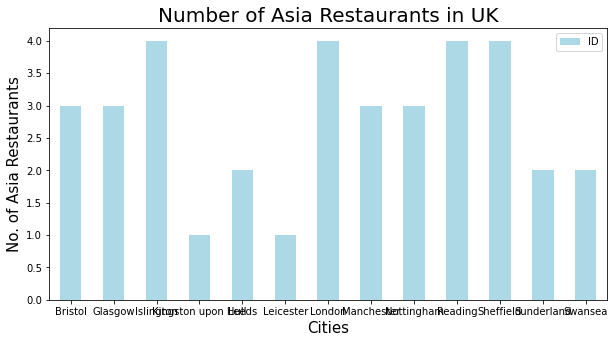

In [12]:
asia_rest_uk.groupby('City')['ID'].count().plot.bar(figsize=(10,5), color='lightblue')
plt.title('Number of Asia Restaurants in UK', fontsize = 20)
plt.xlabel('Cities', fontsize = 15)
plt.ylabel('No. of Asia Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()



Now we will get the ranking of each restaurant for further analysis.


In [13]:
asia_uk

,Index,City,ID,Name
0,0,London,527bee27498e2ccd501fe6dc,Sticks'n'Sushi
1,1,London,58c575e4260327384ab298a9,wagamama
2,2,London,4c8d8002cf3ea14343c1fe51,Thai Square
3,3,London,5c10e0201de76500398bf8e0,CoCo Ichibanya
4,4,Nottingham,564652ba498e954762aacbfc,ZAAP Thai street food
5,5,Nottingham,4b7bfb82f964a520f1762fe3,wagamama
6,6,Nottingham,4bb2342214cfd13a6d9d14ab,Chino Latino
7,7,Sheffield,4e58d2eb45dd7055928d8026,Edo Sushi
8,8,Sheffield,4b61f234f964a520bb2c2ae3,wagamama
9,9,Sheffield,4babe37cf964a52070d23ae3,Sakushi


In [14]:
column_names=['City', 'ID','Name','Likes','Rating','Tips']
asia_rest_stats_uk=pd.DataFrame(columns=column_names)

count=1
for row in asia_uk.values.tolist():
    Index, City ,ID ,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id ,name ,likes ,rating ,tips =[0]*5
    print('(',count,'/',len(asia_rest_uk),')','processed')
    asia_rest_stats_uk = asia_rest_stats_uk.append({'City': City, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
asia_rest_stats_uk.tail()

{'meta': {'code': 200, 'requestId': '5fc33190ed02d54fbf0fb236'}, 'response': {'venue': {'id': '527bee27498e2ccd501fe6dc', 'name': "Sticks'n'Sushi", 'contact': {'phone': '+442031418810', 'formattedPhone': '+44 20 3141 8810', 'twitter': 'sticksnsushi_uk', 'instagram': 'sticksnsushi', 'facebook': '267553336636276', 'facebookUsername': 'sticksnsushiuk', 'facebookName': "Sticks'n'Sushi"}, 'location': {'address': '11 Henrietta St', 'lat': 51.511038, 'lng': -0.123655, 'labeledLatLngs': [{'label': 'display', 'lat': 51.511038, 'lng': -0.123655}], 'postalCode': 'WC2E 8PY', 'cc': 'GB', 'city': 'London', 'state': 'Greater London', 'country': 'United Kingdom', 'formattedAddress': ['11 Henrietta St', 'London', 'Greater London', 'WC2E 8PY', 'United Kingdom']}, 'canonicalUrl': 'https://foursquare.com/v/sticksnsushi/527bee27498e2ccd501fe6dc', 'categories': [{'id': '4bf58dd8d48988d1d2941735', 'name': 'Sushi Restaurant', 'pluralName': 'Sushi Restaurants', 'shortName': 'Sushi', 'icon': {'prefix': 'https:/

,City,ID,Name,Likes,Rating,Tips
31,Reading,53653c10498e58bd4e7380af,Coconut Bar & Kitchen,47,7.7,19
32,Reading,4b141441f964a520ef9c23e3,YO! Sushi,50,7.1,16
33,Kingston upon Hull,4bc76d1f6501c9b669693e29,Yin Ji Bar Restaurant,12,7.7,8
34,Swansea,4b8bef8ff964a52052b332e3,Wild Swan,2,5.6,3
35,Swansea,0,0,0,0.0,0


### Visualization

In [15]:
asia_rest_stats_uk.to_csv('asia_rest_stats_uk.csv') 

In [16]:
asia_rest_stats_uk.shape

(36, 6)

In [17]:
asia_rest_stats_uk.info()
asia_rest_stats_uk = asia_rest_stats_uk[asia_rest_stats_uk.ID !=0]
asia_rest_stats_uk['Likes'] = asia_rest_stats_uk['Likes'].astype('float64')
asia_rest_stats_uk['Tips'] = asia_rest_stats_uk['Tips'].astype('float64')
asia_rest_stats_uk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   City    36 non-null     object 
 1   ID      36 non-null     object 
 2   Name    36 non-null     object 
 3   Likes   36 non-null     object 
 4   Rating  36 non-null     float64
 5   Tips    36 non-null     object 
dtypes: float64(1), object(5)
memory usage: 1.8+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 34 entries, 0 to 34
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   City    34 non-null     object 
 1   ID      34 non-null     object 
 2   Name    34 non-null     object 
 3   Likes   34 non-null     float64
 4   Rating  34 non-null     float64
 5   Tips    34 non-null     float64
dtypes: float64(3), object(3)
memory usage: 1.9+ KB


In [18]:
asia_rest_stats_uk.describe()

,Likes,Rating,Tips
count,34.000000,34.000000,34.000000
mean,66.794118,7.741176,24.441176
std,131.925089,0.892432,44.774987
min,2.000000,5.600000,3.000000
25%,14.000000,7.325000,6.000000
50%,41.000000,7.800000,13.000000
75%,54.750000,8.300000,22.750000
max,774.000000,9.100000,257.000000


In [19]:
# Resturant with maximum Likes
asia_rest_stats_uk.loc[asia_rest_stats_uk['Likes'].idxmax()]

City                        London
ID        527bee27498e2ccd501fe6dc
Name                Sticks'n'Sushi
Likes                          774
Rating                           9
Tips                           257
Name: 0, dtype: object

In [20]:
# Resturant with maximum Rating
asia_rest_stats_uk.loc[asia_rest_stats_uk['Rating'].idxmax()]

City                     Sheffield
ID        4e58d2eb45dd7055928d8026
Name                     Edo Sushi
Likes                           37
Rating                         9.1
Tips                            15
Name: 7, dtype: object

In [21]:
# Resturant with maximum Tips
asia_rest_stats_uk.loc[asia_rest_stats_uk['Tips'].idxmax()]

City                        London
ID        527bee27498e2ccd501fe6dc
Name                Sticks'n'Sushi
Likes                          774
Rating                           9
Tips                           257
Name: 0, dtype: object

Resturant with maximum Likes and maximum Tips is Sticks'n'Sushi in London. 
Resturant with highest rating is Edo Sushi in Sheffield.

In [22]:
asia_rest_stats_uk.head()

,City,ID,Name,Likes,Rating,Tips
0,London,527bee27498e2ccd501fe6dc,Sticks'n'Sushi,774.0,9.0,257.0
1,London,58c575e4260327384ab298a9,wagamama,41.0,8.2,12.0
2,London,4c8d8002cf3ea14343c1fe51,Thai Square,125.0,8.0,49.0
3,London,5c10e0201de76500398bf8e0,CoCo Ichibanya,39.0,9.0,9.0
4,Nottingham,564652ba498e954762aacbfc,ZAAP Thai street food,77.0,8.7,25.0


In [23]:
uk_neighborhood_stats_rating=asia_rest_stats_uk.groupby('City',as_index=False).mean()[['City','Rating','Likes','Tips']]
uk_neighborhood_stats_rating.columns=['City','Average Rating','Average Likes','Average Tips']
uk_neighborhood_stats_rating.sort_values(['Average Rating'],ascending=False).head(10)

uk_neighborhood_stats_rating

,City,Average Rating,Average Likes,Average Tips
0,Bristol,7.733333,16.666667,6.666667
1,Glasgow,8.000000,49.666667,19.000000
2,Islington,7.550000,66.750000,25.000000
3,Kingston upon Hull,7.700000,12.000000,8.000000
4,Leeds,7.300000,30.500000,9.000000
5,Leicester,7.600000,5.000000,3.000000
6,London,8.550000,244.750000,81.750000
7,Manchester,8.300000,78.000000,34.666667
8,Nottingham,8.033333,57.000000,24.000000
9,Reading,7.800000,53.500000,17.250000


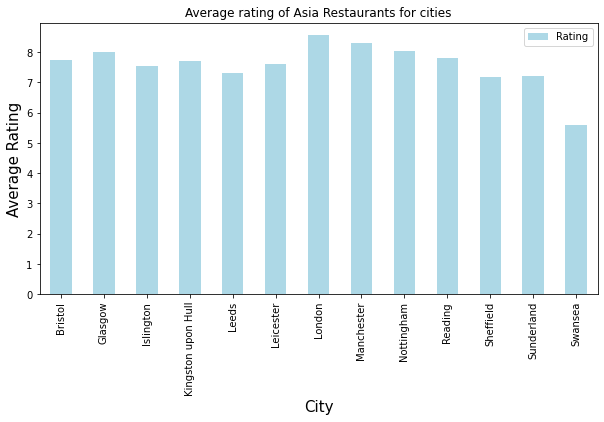

In [24]:
plt.figure(figsize=(10,5))
plt.title('Average rating of Asia Restaurants for cities')
plt.xlabel('Cities', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
asia_rest_stats_uk.groupby('City').mean()['Rating'].plot(kind='bar', color='lightblue')
plt.legend()
plt.show()

In [25]:
asia_rest_stats_uk

,City,ID,Name,Likes,Rating,Tips
0,London,527bee27498e2ccd501fe6dc,Sticks'n'Sushi,774.0,9.0,257.0
1,London,58c575e4260327384ab298a9,wagamama,41.0,8.2,12.0
2,London,4c8d8002cf3ea14343c1fe51,Thai Square,125.0,8.0,49.0
3,London,5c10e0201de76500398bf8e0,CoCo Ichibanya,39.0,9.0,9.0
4,Nottingham,564652ba498e954762aacbfc,ZAAP Thai street food,77.0,8.7,25.0
5,Nottingham,4b7bfb82f964a520f1762fe3,wagamama,79.0,7.9,34.0
6,Nottingham,4bb2342214cfd13a6d9d14ab,Chino Latino,15.0,7.5,13.0
7,Sheffield,4e58d2eb45dd7055928d8026,Edo Sushi,37.0,9.1,15.0
8,Sheffield,4b61f234f964a520bb2c2ae3,wagamama,45.0,7.3,13.0
9,Sheffield,4babe37cf964a52070d23ae3,Sakushi,30.0,6.4,14.0


In [26]:
uk_neighborhood_stats=pd.merge(asia_rest_stats_uk,myuk_df, on='City')
#hk_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
uk_neighborhood_stats

,City,ID,Name,Likes,Rating,Tips,Coordinates,Latitude,Longitude
0,London,527bee27498e2ccd501fe6dc,Sticks'n'Sushi,774.0,9.0,257.0,"51.50853, -0.12574",51.50853,-0.12574
1,London,58c575e4260327384ab298a9,wagamama,41.0,8.2,12.0,"51.50853, -0.12574",51.50853,-0.12574
2,London,4c8d8002cf3ea14343c1fe51,Thai Square,125.0,8.0,49.0,"51.50853, -0.12574",51.50853,-0.12574
3,London,5c10e0201de76500398bf8e0,CoCo Ichibanya,39.0,9.0,9.0,"51.50853, -0.12574",51.50853,-0.12574
4,Nottingham,564652ba498e954762aacbfc,ZAAP Thai street food,77.0,8.7,25.0,"52.9536, -1.15047",52.95360,-1.15047
5,Nottingham,4b7bfb82f964a520f1762fe3,wagamama,79.0,7.9,34.0,"52.9536, -1.15047",52.95360,-1.15047
6,Nottingham,4bb2342214cfd13a6d9d14ab,Chino Latino,15.0,7.5,13.0,"52.9536, -1.15047",52.95360,-1.15047
7,Sheffield,4e58d2eb45dd7055928d8026,Edo Sushi,37.0,9.1,15.0,"53.38297, -1.4659",53.38297,-1.46590
8,Sheffield,4b61f234f964a520bb2c2ae3,wagamama,45.0,7.3,13.0,"53.38297, -1.4659",53.38297,-1.46590
9,Sheffield,4babe37cf964a52070d23ae3,Sakushi,30.0,6.4,14.0,"53.38297, -1.4659",53.38297,-1.46590


In [27]:
address = 'United Kingdom'

geolocator = Nominatim(user_agent="myapp")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of UK are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of UK are 54.7023545, -3.2765753.


In [28]:
uk_neighborhood_stats_rating.head()

,City,Average Rating,Average Likes,Average Tips
0,Bristol,7.733333,16.666667,6.666667
1,Glasgow,8.000000,49.666667,19.000000
2,Islington,7.550000,66.750000,25.000000
3,Kingston upon Hull,7.700000,12.000000,8.000000
4,Leeds,7.300000,30.500000,9.000000


In [29]:
myuk_df2 =pd.merge(myuk_df,uk_neighborhood_stats_rating, on='City')
myuk_df2['Label']=myuk_df2['City']+', '+'('+ myuk_df2['Average Rating'].map(str)+')'
myuk_df2

,City,Coordinates,Latitude,Longitude,Average Rating,Average Likes,Average Tips,Label
0,London,"51.50853, -0.12574",51.50853,-0.12574,8.550000,244.750000,81.750000,"London, (8.55)"
1,Nottingham,"52.9536, -1.15047",52.95360,-1.15047,8.033333,57.000000,24.000000,"Nottingham, (8.033333333333333)"
2,Sheffield,"53.38297, -1.4659",53.38297,-1.46590,7.175000,29.500000,11.500000,"Sheffield, (7.174999999999999)"
3,Bristol,"51.45523, -2.59665",51.45523,-2.59665,7.733333,16.666667,6.666667,"Bristol, (7.733333333333333)"
4,Glasgow,"55.86515, -4.25763",55.86515,-4.25763,8.000000,49.666667,19.000000,"Glasgow, (8.0)"
5,Leicester,"52.6386, -1.13169",52.63860,-1.13169,7.600000,5.000000,3.000000,"Leicester, (7.6)"
6,Leeds,"53.79648, -1.54785",53.79648,-1.54785,7.300000,30.500000,9.000000,"Leeds, (7.300000000000001)"
7,Manchester,"53.48095, -2.23743",53.48095,-2.23743,8.300000,78.000000,34.666667,"Manchester, (8.3)"
8,Sunderland,"54.90465, -1.38222",54.90465,-1.38222,7.200000,9.000000,4.000000,"Sunderland, (7.2)"
9,Islington,"51.53622, -0.10304",51.53622,-0.10304,7.550000,66.750000,25.000000,"Islington, (7.549999999999999)"


In [36]:
# create map
map_uk = folium.Map(location=[latitude, longitude], zoom_start=10.25)

for lat, lng, city,label in zip(myuk_df2['Latitude'],myuk_df2['Longitude'],myuk_df2['City'],myuk_df2['Label']):
    label = '{}'.format(label)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_uk)  
       
map_uk 

##Result, Conclusion and Limitation
In the UK, London and Manchester have relative high rate chinese restaurants in average. Swansea has lowest rate chinese restaurants in average. Resturant with maximum Likes and maximum Tips is Sticks'n'Sushi in London. Resturant with highest rating is Edo Sushi in Sheffield. Chinese restaurant only have 9 restaraunt in the UK. It is the niche market for chinese cuisine. Sushi is easier to have a higher rating for the restaurant, but also in a higher competition.    

In Conclusion, We would recommend the local catering company to open a chinese restaurant in London and Manchester since they have more experience on local restaurant. But for Hong Kong immigrant would be suitable to open in swansea with less competiion to gain the reputation faster at the begining. 

Due to the limited data from Foursqaure, analysis cannot have a fully picture on the distribution of all restaurant in the UK. Further detail research and analysis have to made and more data from external database. 
